<a href="https://colab.research.google.com/github/zahra-sharifzadeh/thesis_demo/blob/main/Ravdess/spa_ca_Att_w2v/demo_second_K1_kfold_att_w2v_SpatialAttention_and_channel_attention_dropout_mfc_coefficients_two_CNNAE_Parallel_Ravdess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Setup

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import librosa
import librosa.display
import torch.nn.functional as F

import IPython
from IPython.display import Audio

from IPython.display import Image
import warnings; warnings.filterwarnings('ignore') #matplot lib complains about librosa

In [ ]:
try:
  from transformers import Wav2Vec2Model, Wav2Vec2Processor
except:
  !pip install transformers
  from transformers import Wav2Vec2Model, Wav2Vec2Processor


In [ ]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Check extracted audio waveforms and labels:


In [ ]:
emotions_dict ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}

# Additional attributes from RAVDESS to play with
emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}

In [ ]:
##### LOAD #########
# choose load file name
filename = '/content/gdrive/MyDrive/att_w2v_kfold/k1/features+rawAudio+labels.npy'

# open file in read mode and read data
with open(filename, 'rb') as f:
    features_train = np.load(f)
    X_train = np.load(f)
    # features_valid = np.load(f)

    features_test = np.load(f)
    X_test = np.load(f)

    y_train = np.load(f)
    # y_valid = np.load(f)
    y_test = np.load(f)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, features_train:{features_train.shape}, y_train:{y_train.shape}')
# print(f'X_valid:{features_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test:{X_test.shape} features_test: {features_test.shape}, y_test:{y_test.shape}')

X_train:(3870, 48000), features_train:(3870, 1, 40, 94), y_train:(3870,)
X_test:(429, 48000) features_test: (429, 1, 40, 94), y_test:(429,)


In [ ]:
X_train.shape

(3870, 48000)

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels * 2, 1, kernel_size=1)  # Double the channels in the convolution
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Assuming x has shape [batches, 64, 1, 8]
        avg_pool = F.avg_pool2d(x, kernel_size=(1, x.size(3)))
        max_pool = F.max_pool2d(x, kernel_size=(1, x.size(3)))

        # Double the channels in the features concatenation
        features = torch.cat([avg_pool, max_pool], dim=1)

        attention = self.conv1(features)
        attention = self.sigmoid(attention)

        # Applying attention to the input tensor along the spatial dimension
        x = x * attention

        return x

# Example usage
batches, channels, height, width = 2, 64, 1, 2
input_tensor = torch.randn(batches, channels, height, width)
attention_module = SpatialAttention(in_channels=channels)
output_tensor = attention_module(input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)


Input shape: torch.Size([2, 64, 1, 2])
Output shape: torch.Size([2, 64, 1, 2])


In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pool = self.avg_pool(x).view(x.size(0), -1)
        max_pool = self.max_pool(x).view(x.size(0), -1)
        channel_att = self.fc(avg_pool + max_pool).view(x.size(0), x.size(1), 1, 1)
        x = x * channel_att
        return x


# Example usage
batches, channels, height, width = 2, 64, 1, 2
input_tensor = torch.randn(batches, channels, height, width)
attention_module = ChannelAttention(in_channels=channels)
output_tensor = attention_module(input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)



Input shape: torch.Size([2, 64, 1, 2])
Output shape: torch.Size([2, 64, 1, 2])


In [ ]:
import torch
import torch.nn as nn

class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()

        self.encoder1 = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),

            # 2nd 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),

            # 3rd 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )

    def forward(self, x):
        return self.encoder1(x)





In [ ]:
class Decoder1(nn.Module):
    def __init__(self):
        super(Decoder1, self).__init__()

        self.decoder1 = nn.Sequential(
            # 1st 2D transpose convolution layer
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=(1, 4), padding=0, output_padding=(0, 2)),
            nn.BatchNorm2d(32),
            nn.SELU(),

            # 2nd 2D transpose convolution layer
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=4, padding=0, output_padding=(1, 2)),
            nn.BatchNorm2d(16),
            nn.SELU(),

            # 3rd 2D transpose convolution layer
            nn.ConvTranspose2d(16, 1, kernel_size=(3,7), stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        return self.decoder1(x)


In [ ]:

class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        self.encoder = Encoder1()
        self.spatial_attention = SpatialAttention(64)
        self.channel_attention = ChannelAttention(64)
        self.decoder = Decoder1()

    def forward(self, x):
        encoded = self.encoder(x)
        # print("encoded1:", encoded.shape)
        sa = self.spatial_attention(encoded)
        # print("sa1:",sa.shape)
        ca = self.channel_attention(encoded)
        # print("ca1:", ca.shape)
        att_encoded = sa + ca + encoded

        decoded = self.decoder(att_encoded)
        return encoded, decoded


In [ ]:
# Example usage
autoencoder = Autoencoder1()
input_data = torch.randn(1, 1, 40, 94)  # Replace with your input shape
encoded1, decoded1 = autoencoder(input_data)
encoded1.shape, decoded1.shape

(torch.Size([1, 64, 1, 2]), torch.Size([1, 1, 40, 94]))

In [ ]:
import torch.nn as nn

class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()

        # Define the 2D convolutional layers
        self.conv2Dblock = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),

            # 2nd 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),

            # 3rd 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )

    def forward(self, x):
        # Pass the input through the convolutional layers
        return self.conv2Dblock(x)



In [ ]:
import torch.nn as nn

class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()

        # Define the 2D transposed convolutional layers for the decoder
        self.decoder2 = nn.Sequential(
            # 1st 2D transposed convolution layer
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=(1, 4), padding=0, output_padding=(0, 2)),
            nn.BatchNorm2d(32),
            nn.SELU(),

            # 2nd 2D transposed convolution layer
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=4, padding=0, output_padding=(1, 2)),
            nn.BatchNorm2d(16),
            nn.SELU(),

            # 3rd 2D transposed convolution layer
            nn.ConvTranspose2d(16, 1, kernel_size=(3,7), stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Pass the input through the decoder's transposed convolutional layers
        return self.decoder2(x)



In [ ]:
import torch.nn as nn

class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()

        # Define the encoder and decoder
        self.encoder = Encoder2()
        self.spatial_attention = SpatialAttention(64)
        self.channel_attention = ChannelAttention(64)
        self.decoder = Decoder2()

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)
        sa = self.spatial_attention(encoded)
        ca = self.channel_attention(encoded)
        att_encoded = sa + ca + encoded

        # Decode the encoded representation
        decoded = self.decoder(att_encoded)
        return encoded, decoded
# Example usage
autoencoder2 = Autoencoder2()
input_data = torch.randn(1, 1, 40, 94)  # Replace with your input shape
encoded2, decoded2 = autoencoder2(input_data)
encoded2.shape, decoded2.shape


(torch.Size([1, 64, 1, 2]), torch.Size([1, 1, 40, 94]))

In [ ]:
X_train.shape

(3870, 48000)

In [ ]:
import torch.nn as nn

class EmotionClassifier(nn.Module):
    def __init__(self, num_emotions):
        super(EmotionClassifier, self).__init__()

        # Linear softmax layer to take the final concatenated embedding tensor
        # from parallel 2D convolutional and transformer blocks, output 8 logits
        # Each full convolution block outputs (64*1*8) embedding flattened to dim 512 1D array
        # Full transformer block outputs 40*70 feature map, which we time-avg to dim 40 1D array
        # 512*2 + 40 == 1064 input features --> 8 output emotions
        self.fc1_linear = nn.Linear(128*3 , 128)
        self.fc2_linear = nn.Linear(128 , num_emotions)
        self.drop = nn.Dropout(p=0.1)



        # Softmax layer for the 8 output logits from the final FC linear layer
        self.softmax_out = nn.Softmax(dim=1)  # dim==1 refers to the frequency embedding

    def forward(self,x):

        # Pass the concatenated features through the final linear layer
        out1 = self.fc1_linear(x)
        out1 = self.drop(out1)
        output = self.fc2_linear(out1)


        # Apply softmax to get the class probabilities
        class_probs = self.softmax_out(output)

        return output , class_probs

# You can use this EmotionClassifier as part of your larger model to perform emotion classification.


In [ ]:
# Combine the models



class MultiTaskModel(nn.Module):
    def __init__(self,num_emotions):

        super(MultiTaskModel, self).__init__()
        self.autoencoder1 = Autoencoder1()
        self.autoencoder2 = Autoencoder2()
        # self.transformerblock = TransformerBlock()
        self.emotion_classifier = EmotionClassifier(num_emotions)
        self.post_spec_mfcc_att_dropout = nn.Dropout(p=0.1)
        self.post_spec_mfcc_att_layer = nn.Linear(256, 149)
        self.post_wav_dropout = nn.Dropout(p=0.1)
        self.post_wav_layer = nn.Linear(768, 128) # 512 for 1 and 768 for 2
        self.drop = nn.Dropout(p=0.1)






    def forward(self, x, y):

        # print(w2v_features.shape)






        encoded1, decoded1 = self.autoencoder1(x)
        encoded1_embedding1 = torch.flatten(encoded1, start_dim=1)
        # print("encoded1_embedding1", encoded1_embedding1.shape)
        encoded2, decoded2= self.autoencoder2(x)
        encoded2_embedding2 = torch.flatten(encoded2, start_dim=1)
        # print("encoded1_embedding2", encoded2_embedding2.shape)


        # FOR WAV2VEC2.0 WEIGHTS
        spec_mfcc = torch.cat([encoded1_embedding1, encoded2_embedding2], dim=-1) # [batch, 256]
        audio_spec_mfcc_att_d = self.post_spec_mfcc_att_dropout(spec_mfcc)# [batch, 256]
        audio_spec_mfcc_att_p = F.relu(self.post_spec_mfcc_att_layer(audio_spec_mfcc_att_d), inplace=False)# [batch, 149]
        audio_spec_mfcc_att_p = audio_spec_mfcc_att_p.reshape(audio_spec_mfcc_att_p.shape[0], 1, -1)# [batch, 1, 149]
        #+ audio_spec_mfcc_att_2 = F.softmax(audio_spec_mfcc_att_1, dim=2)

        # wav2vec 2.0
        audio_wav = y # [batch, 149, 768]
        audio_wav = torch.matmul(audio_spec_mfcc_att_p, audio_wav) # [batch, 1, 768]
        audio_wav = audio_wav.reshape(audio_wav.shape[0], -1) # [batch, 768]
        #audio_wav = torch.mean(audio_wav, dim=1)
        audio_wav_d = self.post_wav_dropout(audio_wav) # [batch, 768]
        audio_wav_p = F.relu(self.post_wav_layer(audio_wav_d), inplace=False) # [batch, 128]





        complete_embedding = torch.cat([encoded1_embedding1, encoded2_embedding2,audio_wav_p], dim=1)
        complete_embedding = self.drop(complete_embedding)

        # print("complete_embedding", complete_embedding.shape)


        output_logits, output_softmax = self.emotion_classifier(complete_embedding)

        return decoded1, decoded2, output_logits, output_softmax

In [ ]:
# Example usage
model = MultiTaskModel(num_emotions=8)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

input_data = torch.randn(2, 1, 40, 94)  # Replace with your input shape
input_data2 = torch.randn( 2, 149, 768)  # Replace with your input shape
# print(input_data2.unsqueeze(dim=1).shape)
# rrr= input_data2.unsqueeze(dim=1)
decoded1, decoded2, output_logits, output_softmax = model(input_data,input_data2)
decoded1.shape, decoded2.shape, output_logits, output_softmax


Number of trainable params:  348073


(torch.Size([2, 1, 40, 94]),
 torch.Size([2, 1, 40, 94]),
 tensor([[ 0.6693, -0.8089, -1.9439,  1.8465, -0.6682,  0.1512, -1.5151,  0.8064],
         [-1.1953, -0.0715, -1.4157, -0.2452, -0.0030, -0.9579,  0.9569, -1.2549]],
        grad_fn=<AddmmBackward0>),
 tensor([[0.1501, 0.0342, 0.0110, 0.4870, 0.0394, 0.0894, 0.0169, 0.1721],
         [0.0464, 0.1426, 0.0372, 0.1199, 0.1527, 0.0588, 0.3988, 0.0437]],
        grad_fn=<SoftmaxBackward0>))

In [ ]:
# Loss functions
autoencoder_criterion = nn.MSELoss()  # Use Mean Squared Error for autoencoder loss
classifier_criterion = nn.CrossEntropyLoss()  # Use Cross-Entropy for emotion classification loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

In [ ]:
# define function to create a single step of the training phase
def make_train_step(model, autoencoder_criterion, classifier_criterion, optimizer):

    # define the training step of the training phase
    def train_step(X, features, Y):
        model.train()


        # forward pass
        decoded1, decoded2, output_logits, output_softmax  = model(X, features)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))

        # Compute losses
        autoencoder_loss1 = autoencoder_criterion(decoded1, X)
        autoencoder_loss2 = autoencoder_criterion(decoded2, X)
        classifier_loss = classifier_criterion(output_logits, Y)

        # Define a trade-off parameter to balance losses
        tradeoff = 0.4 # Adjust as needed

        # Calculate the combined loss
        loss = tradeoff * (autoencoder_loss1 + autoencoder_loss2) + (1 - tradeoff) * classifier_loss

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100, autoencoder_loss1.item(), autoencoder_loss2.item(), classifier_loss.item()
    return train_step

In [ ]:
def make_validate_fnc(model,autoencoder_criterion, classifier_criterion):
    def validate(X,features,Y):

        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase:
        with torch.no_grad():

            # set model to validation phase i.e. turn off dropout and batchnorm layers
            model.eval()

            # get the model's predictions on the validation set
            decoded1, decoded2, output_logits, output_softmax  = model(X, features)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))

            # Compute losses
            autoencoder_loss1 = autoencoder_criterion(decoded1, X)
            autoencoder_loss2 = autoencoder_criterion(decoded2, X)
            classifier_loss = classifier_criterion(output_logits, Y)

            # compute error from logits (nn.crossentropy implements softmax)
            # Define a trade-off parameter to balance losses
            tradeoff = 0.4 # Adjust as needed

            # Calculate the combined loss
            loss = tradeoff * (autoencoder_loss1 + autoencoder_loss2) + (1 - tradeoff) * classifier_loss


        return loss.item(), accuracy*100, autoencoder_loss1.item(), autoencoder_loss2.item(), classifier_loss.item(), predictions
    return validate

In [ ]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [ ]:
# get training set size to calculate # iterations and minibatch indices
train_size = X_train.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')



cpu selected


In [ ]:
# pick load folder
load_folder = '/content/gdrive/MyDrive/att_w2v_kfold/k1'

# pick the epoch to load
epoch = '60'
model_name = f'k_1_kfold-att_w2v_SpatialAttention_and_channel_attention_dropout.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary
device = 'cuda' if  torch.cuda.is_available() else 'cpu'
model = MultiTaskModel(len(emotions_dict)).to(device)
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from /content/gdrive/MyDrive/att_w2v_kfold/k1/k_1_kfold-att_w2v_SpatialAttention_and_channel_attention_dropout.pkl


In [ ]:
# instantiate model and move to GPU for training
# model = MultiTaskModel(num_emotions=len(emotions_dict)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

Number of trainable params:  348073


In [ ]:
# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001, weight_decay=1e-3)
# Loss functions
autoencoder_criterion = nn.MSELoss()  # Use Mean Squared Error for autoencoder loss
classifier_criterion = nn.CrossEntropyLoss()  # Use Cross-Entropy for emotion classification loss

In [ ]:
# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function
train_step = make_train_step(model, autoencoder_criterion, classifier_criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,autoencoder_criterion, classifier_criterion)



In [ ]:
        # open file in write mode and write data
filename = '/content/gdrive/MyDrive/att_w2v_kfold/k1/losses.npy'

with open(filename, 'rb') as f:
    train_losses = np.load(f)
    train_autoencoder_losses1 =  np.load(f)
    train_autoencoder_losses2 = np.load(f)
    train_classifier_losses = np.load(f)
    valid_losses = np.load(f)
    valid_autoencoder_losses1 = np.load(f)
    valid_autoencoder_losses2 = np.load(f)
    valid_classifier_losses = np.load(f)

In [ ]:
    train_losses = list(train_losses)
    train_autoencoder_losses1 =  list(train_autoencoder_losses1)
    train_autoencoder_losses2 = list(train_autoencoder_losses2)
    train_classifier_losses = list(train_classifier_losses)
    valid_losses = list(valid_losses)
    valid_autoencoder_losses1 = list(valid_autoencoder_losses1)
    valid_autoencoder_losses2 = list(valid_autoencoder_losses2)
    valid_classifier_losses = list(valid_classifier_losses)

In [ ]:

# Load the pretrained model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# features_train
# features_valid
# features_test

In [ ]:
# pick load folder
load_folder = '/content/gdrive/MyDrive/att_w2v_kfold/k1'

# pick the epoch to load
epoch = '60'
model_name = f'k_1_kfold-att_w2v_SpatialAttention_and_channel_attention_dropout.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary
device = 'cuda' if  torch.cuda.is_available() else 'cpu'
model = MultiTaskModel(len(emotions_dict)).to(device)
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from /content/gdrive/MyDrive/att_w2v_kfold/k1/k_1_kfold-att_w2v_SpatialAttention_and_channel_attention_dropout.pkl


In [ ]:
# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Features_train, Y_train, Xvalid, features_valid, Yvalid, train_index, test_index):
    e = 0

    for epoch in range(num_epochs):

        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        Features_train = Features_train[train_indices,:,:,:]
        X_train = X_train[train_indices,:]
        Y_train = Y_train[train_indices]
        # print(X_train.shape,Y_train.shape, Features_train.shape)



        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        epoch_autoencoder_loss1 = 0
        epoch_autoencoder_loss2 = 0
        epoch_classifier_loss = 0




        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            features_train = Features_train[batch_start:batch_end,:,:,:]
            # print('\n',features_train.shape)

            X = X_train[batch_start:batch_end,:]
            # print("pr:", X.shape)

            audio_input = processor(X,
                                    sampling_rate=16000,
                                    return_tensors="pt")
            with torch.no_grad():
              X = w2v(**audio_input).last_hidden_state

            # print("after:", X.shape)




            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            features_train = torch.tensor(features_train, device=device).float()

            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            # Pass input tensors thru 1 training step (fwd+backwards pass)

            loss, acc, autoencoder_loss1, autoencoder_loss2, classifier_loss = train_step(features_train, X_tensor,Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            epoch_autoencoder_loss1 += autoencoder_loss1 * actual_batch_size / train_size
            epoch_autoencoder_loss2 += autoencoder_loss2 * actual_batch_size / train_size
            epoch_classifier_loss += classifier_loss * actual_batch_size / train_size
            e = epoch

            # keep track of the iteration to see if the model's too slow


        # create tensors from validation set
        valid_audio_input = processor(Xvalid,
                                      sampling_rate=16000,
                                      return_tensors="pt")
        with torch.no_grad():
          valid_audio_input_feature = w2v(**valid_audio_input).last_hidden_state
        X_valid_tensor = torch.tensor(valid_audio_input_feature,device=device).float()
        features_valid = torch.tensor(features_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Yvalid,dtype=torch.long,device=device)

        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, valid_autoencoder_loss1, valid_autoencoder_loss2, valid_classifier_loss, _ = validate(features_valid,
                                                                                                                    X_valid_tensor,
                                                                                                                     Y_valid_tensor)

        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        train_autoencoder_losses1.append(epoch_autoencoder_loss1)
        train_autoencoder_losses2.append(epoch_autoencoder_loss2)
        train_classifier_losses.append(epoch_classifier_loss)


        valid_losses.append(valid_loss)
        valid_autoencoder_losses1.append(valid_autoencoder_loss1 )
        valid_autoencoder_losses2.append(valid_autoencoder_loss2 )
        valid_classifier_losses.append(valid_classifier_loss )


        # Save checkpoint of the model
        checkpoint_filename = '/content/gdrive/MyDrive/att_w2v_kfold/second_k1/k_1_kfold-att_w2v_SpatialAttention_and_channel_attention_dropout.pkl'
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)

                ###### SAVE #########
        # choose save file name
        filename = '/content/gdrive/MyDrive/att_w2v_kfold/second_k1/losses.npy'

        # open file in write mode and write data
        with open(filename, 'wb') as f:
            np.save(f, train_losses)
            np.save(f, train_autoencoder_losses1)
            np.save(f, train_autoencoder_losses2)
            np.save(f, train_classifier_losses)
            np.save(f, valid_losses)
            np.save(f, valid_autoencoder_losses1)
            np.save(f, valid_autoencoder_losses2)
            np.save(f, valid_classifier_losses)


        # print(f'Features and labels saved to {filename}')
        # print('\r'+f'Epoch {e}, end='')

        # keep track of each epoch's progress
        # if epoch == num_epochs-1:
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')
        print(f'\nEpoch {epoch} --- epoch_autoencoder_loss1:{epoch_autoencoder_loss1:.3f}, epoch_autoencoder_loss2:{epoch_autoencoder_loss2 :.2f}, epoch_classifier_loss:{epoch_classifier_loss:.3f}')
        print(f'\nEpoch {epoch} --- valid_autoencoder_loss1:{valid_autoencoder_loss1 :.3f}, valid_autoencoder_loss2:{valid_autoencoder_loss2  :.2f}, valid_classifier_loss:{valid_classifier_loss:.3f}\n\n')




In [ ]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
i = 0

train_index, test_index = list(kfold.split(X_train, y_train))[0]

Xtrain, Xvalid = X_train[train_index], X_train[test_index]
ytrain, yvalid = y_train[train_index], y_train[test_index]
FeaturesTrain, FeaturesValid = features_train[train_index], features_train[test_index]
print(Xtrain.shape, Xvalid.shape, FeaturesTrain.shape, FeaturesValid.shape)
train_size = Xtrain.shape[0]







(3483, 48000) (387, 48000) (3483, 1, 40, 94) (387, 1, 40, 94)


In [38]:
num_epochs = 60

# train it!
train(optimizer, model, num_epochs, Xtrain, FeaturesTrain, ytrain, Xvalid, FeaturesValid, yvalid, train_index, test_index)


Epoch 0 --- loss:0.842, Epoch accuracy:91.24%, Validation loss:0.944, Validation accuracy:85.83%

Epoch 0 --- epoch_autoencoder_loss1:0.868, epoch_autoencoder_loss2:0.90, epoch_classifier_loss:0.225

Epoch 0 --- valid_autoencoder_loss1:0.910, valid_autoencoder_loss2:0.93, valid_classifier_loss:0.200



Epoch 1 --- loss:0.827, Epoch accuracy:92.19%, Validation loss:0.952, Validation accuracy:85.83%

Epoch 1 --- epoch_autoencoder_loss1:0.867, epoch_autoencoder_loss2:0.90, epoch_classifier_loss:0.202

Epoch 1 --- valid_autoencoder_loss1:0.912, valid_autoencoder_loss2:0.93, valid_classifier_loss:0.211



Epoch 2 --- loss:0.833, Epoch accuracy:91.87%, Validation loss:0.939, Validation accuracy:86.87%

Epoch 2 --- epoch_autoencoder_loss1:0.868, epoch_autoencoder_loss2:0.90, epoch_classifier_loss:0.211

Epoch 2 --- valid_autoencoder_loss1:0.911, valid_autoencoder_loss2:0.93, valid_classifier_loss:0.190



Epoch 3 --- loss:0.833, Epoch accuracy:91.70%, Validation loss:0.976, Validation accura

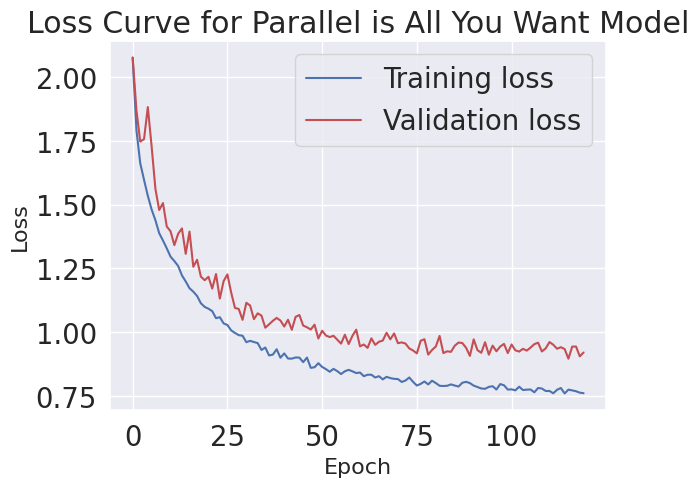

In [46]:
plt.title('Loss Curve for Parallel is All You Want Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [ ]:
# reinitialize validation function with model from chosen checkpoint


validate = make_validate_fnc(model,autoencoder_criterion, classifier_criterion)

test_audio_input = processor(X_test,
                              sampling_rate=16000,
                              return_tensors="pt")
with torch.no_grad():
  test_audio_input_feature = w2v(**test_audio_input).last_hidden_state

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor = torch.tensor(test_audio_input_feature,device=device).float()
features_test = torch.tensor(features_test,device=device).float()

# Convert 4D test label set array to tensor and move to GPU
y_test_tensor = torch.tensor(y_test,dtype=torch.long,device=device)

# Get the model's performance metrics using the validation function we defined
test_loss, test_acc, test_autoencoder_loss1, test_autoencoder_loss2, test_classifier_loss, predicted_emotions = validate(features_test,
                                                                                                                         X_test_tensor,
                                                                                                                         y_test_tensor)
print(f'Test accuracy is {test_acc:.2f}%')

Test accuracy is 81.12%


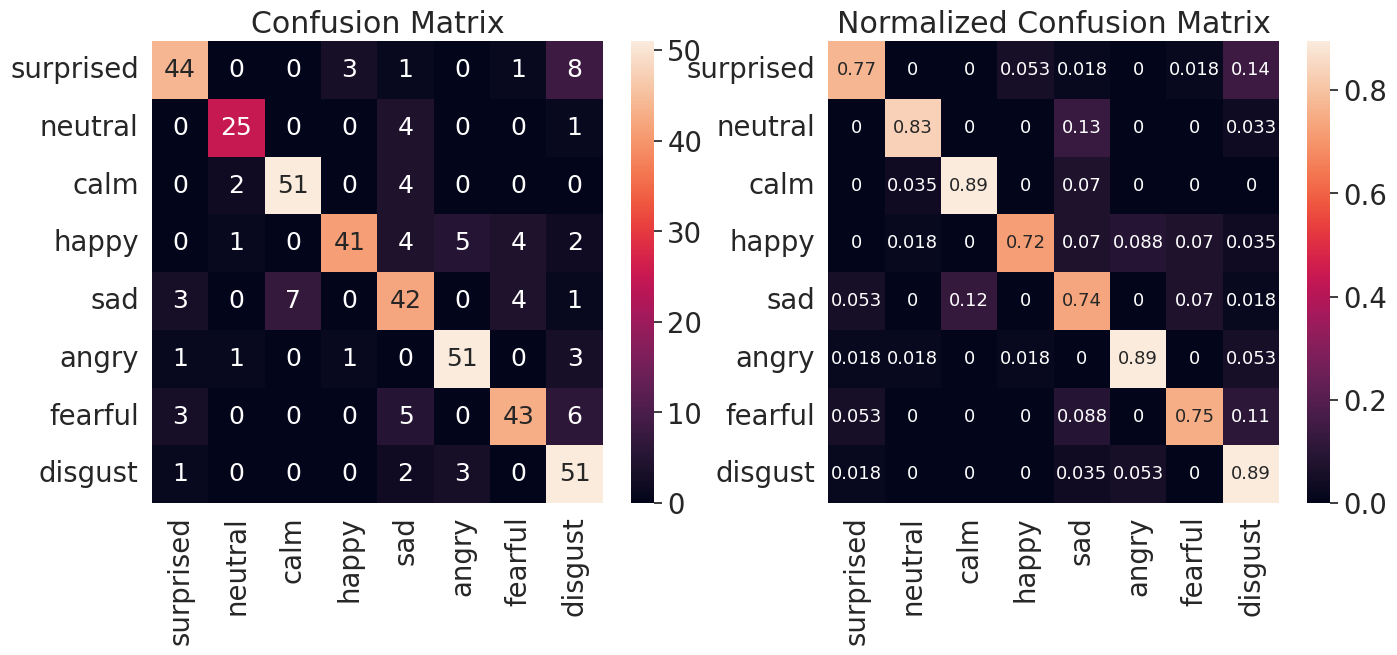

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions.cpu().numpy()
# use labels from test set
emotions_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = [emotion for emotion in emotions_dict.values()]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()